## Chessboard camera calibration

Reference:
- https://medium.com/analytics-vidhya/camera-calibration-with-opencv-f324679c6eb7
- OpenCV-Python Tutorials » Camera Calibration and 3D Reconstruction
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
- https://opencv.org/license/

#### Calibration using: chessboard
Why chessboard test? A chessboard is great for calibration because it's regular, high contrast pattern makes it easy to detect automatically. And we know how an undistorted flat chessboard looks like. So, we use our camera to take pictures of Chessboard at different angles.
#### Calibration of: 
Single camera
#### Input:
Set of images of chessboard calibration test from one camera
#### Output:
- Matrix of intrinsic camera params (mtx)
- Matrix of distortion coefficients (dist) 

## Libraries import

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## Visualization of random image

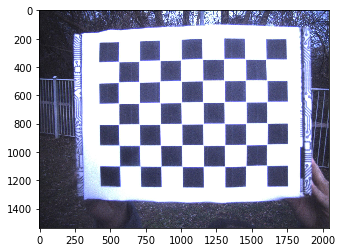

In [11]:
path = 'D:/PYTHON/Checkerboard.jpg'
images = glob.glob(path)
sample_img = np.array(Image.open(path))
plt.imshow(sample_img)
plt.show()

## Determination of intrinsic params
### Directories:

In [3]:
# Input all checkerboard images from one camera (prefer 10-20 images)
images_path = 'D:/PYTHON/image_set/*.jpg'
images = glob.glob(images_path)

### Termination criteria:

In [4]:
# Termination criteria (each small square in chessboard is 25 mm x 25 mm in this case)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 25, 0.001)

# Number of inner vertices:
H = 8 # vertices_horizontal
V = 6 # vertices_vertical  
size = 25 # square size in mm

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((H*V,3), np.float32)
objp[:,:2] = np.mgrid[0:(H),0:(V)].T.reshape(-1,2)

### Finding correct corners

In [5]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space in mm
imgpoints = [] # 2d points in image plane
correct_idx = [] # idx of images with correct corners

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Conversion from RGB to GRAY

    # Find the chess board corners using CV 
    ret, corners = cv2.findChessboardCorners(gray, (H,V), None)
    # If found, add corner coordinates to object points and image points lists (after refining them)
    if ret == True:
        correct_idx.append(idx)
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (H,V), corners2,ret)

num = len(correct_idx)
print('Number of images with correct corners:', num)
print('Idx of these images:')
print(correct_idx)

Number of images with correct corners: 10
Idx of these images:
[5, 7, 8, 9, 10, 13, 14, 21, 22, 23]


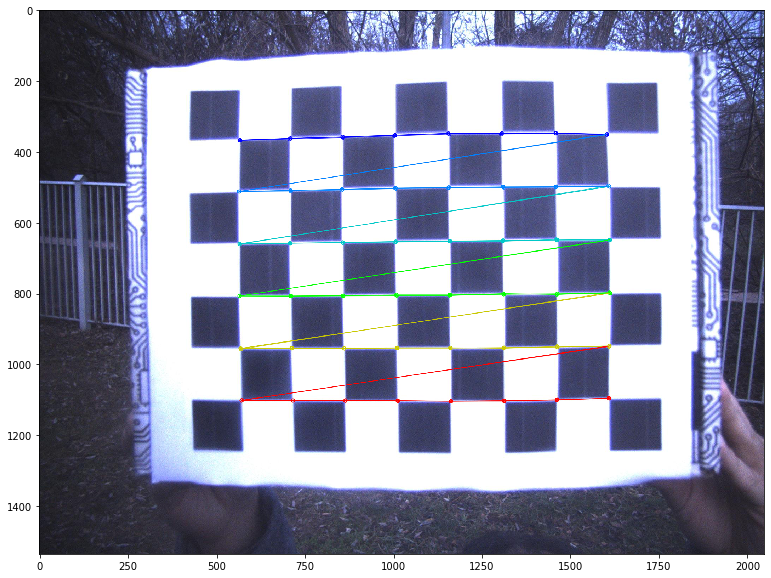

In [24]:
img_sample = sample_img
objpoints_sample=[]
imgpoints_sample=[]
# Find the chess board corners
ret_sample, corners_sample = cv2.findChessboardCorners(gray_sample, (H,V),None)

# If found, add object points, image points (after refining them)
if ret_sample == True:
    objpoints_sample.append(objp)

corners2_sample = cv2.cornerSubPix(gray_sample,corners_sample,(20,20),(5,5),criteria)
imgpoints_sample.append(corners2_sample)

# Draw and display the corners
img_sample = cv2.drawChessboardCorners(img_sample, (H,V), corners2_sample,ret_sample)

plt.figure(figsize=(15,10))
plt.imshow(img_sample);

### Parameters determination:

In [6]:
# For calibration we should use ony images with properly detected corners (with correct_idx)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
num = len(correct_idx)

#Results in pix
## focal length
fx = mtx[0,0]
fy = mtx[1,1]
f_pix = (fx+fy)*0.5

## principal point xp, yp
xp_pix = mtx[0,2]
yp_pix = mtx[1,2]

#Results in mm
## focal length
pixel_size = 0.00345 # in mm
f_mm = pixel_size*f_pix

## principal point xp, yp
xp_mm = pixel_size*mtx[0,2]
yp_mm = pixel_size*mtx[1,2]

# distortion coefficients dist = [k1, k2, p1, p2, k3]
k1 = dist[0,0]
k2 = dist[0,1]
k3 = dist[0,4]
p1 = dist[0,2]
p2 = dist[0,3]

# How do params look like?
print('')
print('fx=', round(fx,3), 'fy=', round(fy,3))
print( "f_pix=", round(f_pix,3),'pix') 
print( "f_mm=", round(f_mm,3), 'mm')


fx= 1821.167 fy= 1825.007
f_pix= 1823.087 pix
f_mm= 6.29 mm


## Accuracy
To calculate calibration accuracy, the absolute norm between what we got with our transformation and the corner finding algorithm should be calculated. To find the average error, we calculate the arithmetical mean of the errors calculated for all the calibration images. 

In [26]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
total_error_pix = mean_error/len(objpoints)
total_error_mm = pixel_size*total_error_pix
print( "total error: +/-{} pix".format(round(total_error_pix,3)) )
print( "total error: +/-{} mm".format(round(total_error_mm,5)) )

total error: +/-0.42 pix
total error: +/-0.00145 mm


## Saving calibration results

In [28]:
save_params_path = "D:/PYTHON/calibration_results.txt"
cv_file = cv2.FileStorage(save_params_path, cv2.FILE_STORAGE_WRITE)

params_to_save = ["f_pix","xp_pix","yp_pix", 'k1', 'k2', 'k3', 'p1', 'p2', "total_error_pix", 
                  "f_mm","xp_mm", "yp_mm", "total_error_mm", "camera_matrix", "dist_coeff"]
params_values = [f_pix, xp_pix, yp_pix, k1, k2, k3, p1, p2, total_error_pix, 
                  f_mm, xp_mm, yp_mm, total_error_mm, mtx, dist]

for idx, param in enumerate(params_to_save):
    cv_file.write(param, params_values[idx])
cv_file.release()

## Undistortion

Now, we can take an image and undistort it. OpenCV comes with two methods for doing this. However first, we can refine the camera matrix based on a free scaling parameter using cv.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. This function also returns an image ROI which can be used to crop the result.

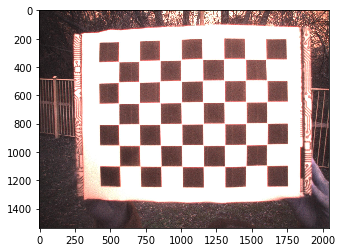

In [7]:
sample_img = cv2.imread('D:/PYTHON/Checkerboard.jpg')
plt.imshow(sample_img);

In [8]:
h,  w = sample_img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [9]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx,(w,h),5)
dst = cv2.remap(sample_img, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('D:/PYTHON/Checkerboard_undistorted.jpg',dst)

True

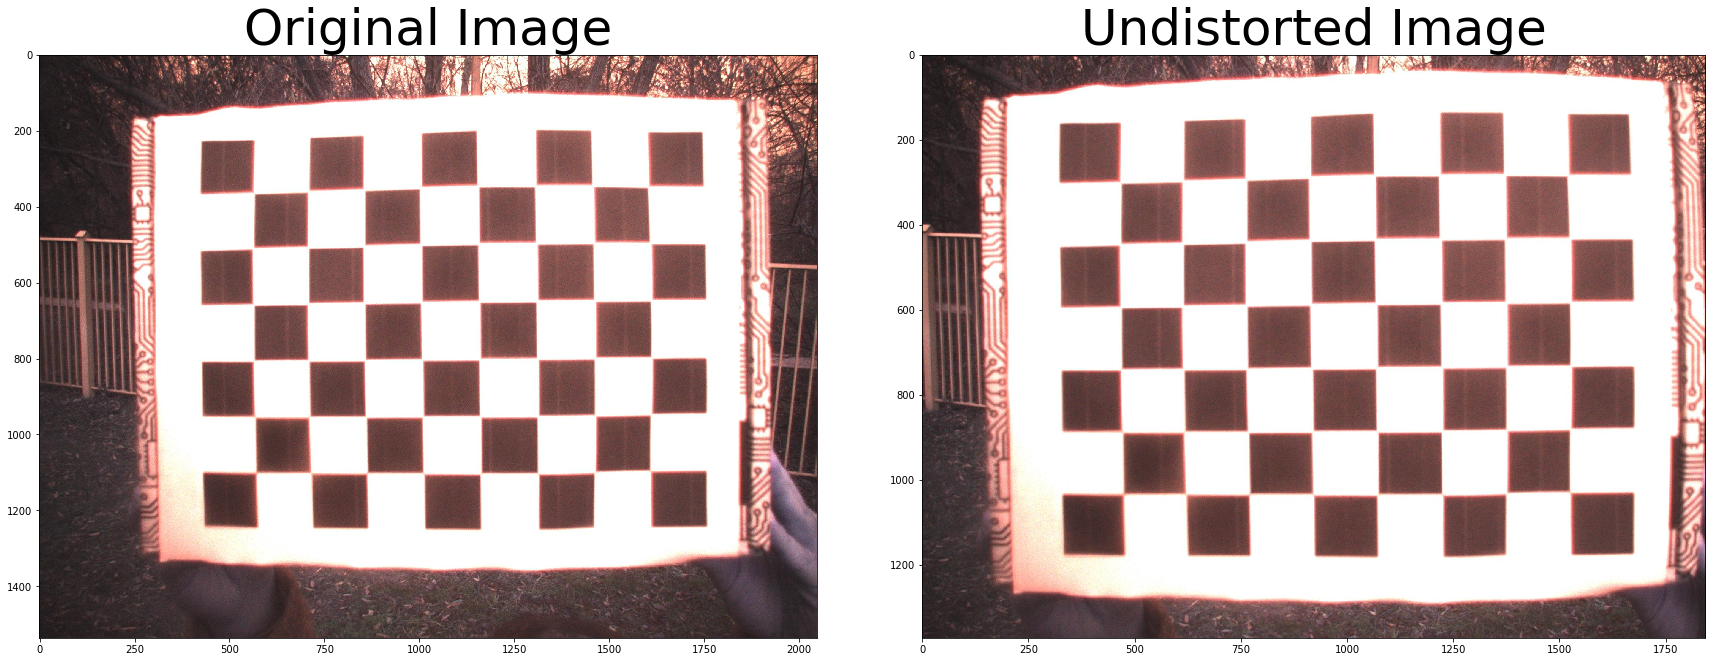

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)